In [1]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Input, Model
from keras.layers import Dense, Layer
from pycalphad import Database, calculate, variables as v
import numpy as np

In [2]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'VA']

In [3]:
import pycalphad
mod = pycalphad.Model(dbf, comps, 'LIQUID')
print(mod.models)
res = calculate(dbf, comps, 'LIQUID', T=(300, 2000, 10), P=1e5, N=1, model=mod, pdens=10)

OrderedDict([('ref', (LIQUID0MG*Piecewise((8202.243 - 8.83693*T - 8.0176e-20*T**7 + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)), And(T < 923.0, 298.15 <= T)), (8690.316 - 9.392158*T - 1.038192e+28*T**(-9) + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)), And(T < 6000.0, 923.0 <= T)), (0, True)) + LIQUID0SI*Piecewise((50696.4 - 30.0994*T + 2.09307e-21*T**7 + Piecewise((-8162.609 + 137.236859*T - 22.8317533*T*log(T) + 176667*T**(-1) - 0.001912904*T**2 - 3.552e-09*T**3, And(T < 1687.0, 298.15 <= T)), (-9457.642 + 167.281367*T - 27.196*T*log(T) - 4.20369e+30*T**(-9), And(T < 3600.0, 1

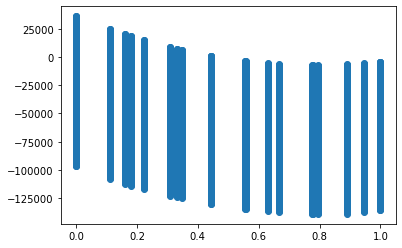

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(res.Y[..., 0], res.GM)

In [5]:
site_fractions = res.Y.values
print(site_fractions.shape)

(1, 1, 170, 22, 2)


In [6]:
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .drop_duplicates()\
                .reset_index()\
                .drop(columns=['N', 'P', 'points'])
# Not sure how to fix the duplicate energy column yet
filtered = filtered.values[:, :1+site_fractions.shape[-1]+1]
x_orig = filtered[:, :-1]
y_orig = filtered[:, -1]

C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
class IdealEntropy(Layer):
    def __init__(self, units=32, input_dim=32):
        super().__init__()

    def call(self, inputs):
        return (inputs[:, 1, None] * tf.math.log(inputs[:,1,None]) + inputs[:, 2, None] * tf.math.log(inputs[:,2,None]))

class Normalization(Layer):
    def __init__(self, input_dim=32, mean=0.0, std=1.0):
        super().__init__() 
        self.mean = mean
        self.std = std
    def call(self, inputs):
        return (inputs - self.mean) / self.std

class DenseLogFeatures(Layer):
    def __init__(self, units=32, input_dim=32, temp_scale=1.0):
        super().__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )
        self.temp_scale = float(temp_scale)

    def call(self, inputs):
        scaled_inputs = inputs * tf.constant([1./self.temp_scale, 1.0, 1.0])
        result = tf.matmul(scaled_inputs, self.w[:inputs.shape[-1]])
        result += tf.matmul(tf.math.multiply(scaled_inputs, tf.math.log(scaled_inputs)), self.w[inputs.shape[-1]:])
        #concatenated = tf.concat([inputs, ], axis=-1)
        return result + self.b
    
class DenseLogFeatures(Layer):
    def __init__(self, units=32, input_dim=32, temp_scale=1.0):
        super().__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )
        self.temp_scale = float(temp_scale)

    def call(self, inputs):
        scaled_inputs = inputs * tf.constant([1./self.temp_scale, 1.0, 1.0])
        result = tf.matmul(scaled_inputs, self.w[:inputs.shape[-1]])
        result += tf.matmul(tf.math.multiply(scaled_inputs, tf.math.log(scaled_inputs)), self.w[inputs.shape[-1]:])
        #concatenated = tf.concat([inputs, ], axis=-1)
        return tf.nn.gelu(result + self.b)

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from numpy.polynomial.legendre import legvander2d
from keras.layers import Dropout, LayerNormalization, Dot

x = x_orig.copy()
#x[:, 0] /= x_orig[:, 0].std()
print('Number of training points: ', x.shape[0])
y_unscaled = y_orig #- 8.3145 * x_orig[:, 0] * (x_orig[:, 1] * np.log(x_orig[:, 1]) + x[:, 2] * np.log(x_orig[:, 2]))
y = (y_unscaled - y_unscaled.mean())/y_unscaled.std()
print('Number of features: ', x.shape[1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1769)
inputs = Input(shape=(x.shape[1],))
output = DenseLogFeatures(units=10, input_dim=2*x.shape[1], temp_scale=x_orig[:, 0].std())(inputs)
output = Dense(units=10, activation='gelu', use_bias=True)(output)
chempots = Dense(2, activation='linear', use_bias=True)(output)
output = Dot(axes=1)([chempots, inputs[:, 1:]]) 
#output = Dense(1, activation='linear', use_bias=True)(output)
linear_model = Model(inputs, output)
linear_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), loss='mse')

Number of training points:  3400
Number of features:  3


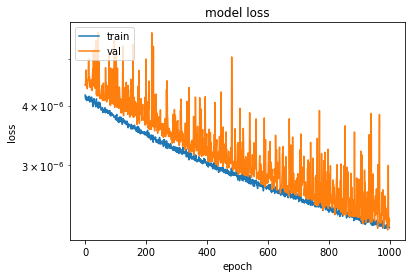

In [61]:
# Fit on training data
history = linear_model.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_test, y_test), verbose=0,
                           callbacks=keras.callbacks.TerminateOnNaN())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

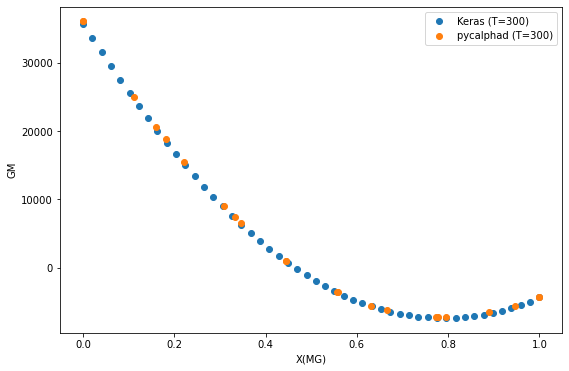

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_at_temp(temp):
    x_start = np.array([temp,1e-4, 1-1e-4])
    x_end = np.array([temp, 1-1e-4, 1e-4])
    x_interp = np.linspace(x_start, x_end, num=50)
    model_y = linear_model.predict(x_interp, batch_size=1)[:,0]
    mod = pycalphad.Model(dbf, comps, 'LIQUID')
    test_calc = calculate(dbf, comps, 'LIQUID', T=temp, P=1e5, N=1, model=mod, pdens=10)
    px_idx = np.argsort(x_interp[:, 1])
    px = x_interp[px_idx, 1]
    model_py = (model_y[px_idx] * y_unscaled.std()) + y_unscaled.mean()
    ax.scatter(px, model_py, label=f'Keras (T={temp})')
    ax.scatter(np.squeeze(test_calc.Y.values)[:, 0], np.squeeze(test_calc.GM.values), label=f'pycalphad (T={temp})')
plot_at_temp(300)
#plot_at_temp(700)
#plot_at_temp(2000)
ax.set_xlabel('X(MG)')
ax.set_ylabel('GM')
ax.legend()

C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1089: RuntimeWarning: invalid v

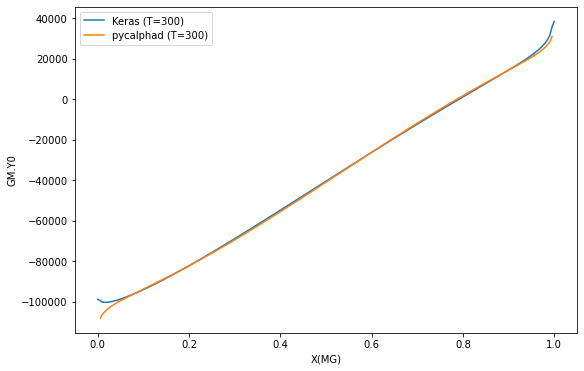

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_gradient_at_temp(temp):
    x_start = np.array([temp,1e-4, 1-1e-4])
    x_end = np.array([temp, 1-1e-4, 1e-4])
    x_interp = np.linspace(x_start, x_end, num=200)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'LIQUID')
    test_calc = calculate(dbf, comps, 'LIQUID', T=temp, P=1e5, N=1, model=mod, pdens=100)
    px_idx = np.argsort(x_interp[:, 1])
    px = x_interp[px_idx, 1]
    model_py = (model_y[px_idx] * y_unscaled.std()) + y_unscaled.mean()
    ax.plot(px, np.gradient(model_py[:, 0], px), label=f'Keras (T={temp})')
    px_idx = np.argsort(np.squeeze(test_calc.Y.values)[:,0])
    px = np.squeeze(test_calc.Y.values)[:, 0][px_idx]
    ax.plot(px, np.gradient(np.squeeze(test_calc.GM.values)[px_idx], px), label=f'pycalphad (T={temp})')
plot_gradient_at_temp(300)
#plot_gradient_at_temp(700)
#plot_gradient_at_temp(1500)
ax.set_xlabel('X(MG)')
ax.set_ylabel('GM.Y0')
ax.legend()

In [64]:
layer_outputs = [layer.output for layer in linear_model.layers] 
# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=linear_model.input, outputs=layer_outputs)

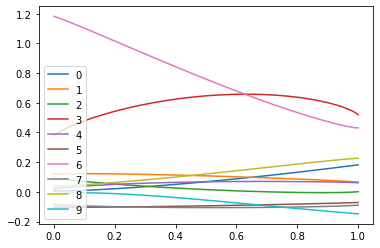

In [65]:
temp = 300
x_start = np.array([temp,1e-4, 1-1e-4])
x_end = np.array([temp, 1-1e-4, 1e-4])
x_interp = np.linspace(x_start, x_end, num=100)
activations = activation_model.predict(x_interp)
[plt.plot(x_interp[:,1], act, label=idx) for idx, act in enumerate(activations[1].T)]
plt.legend(loc='lower left')